# Welcome to our documentation notebook!
In this notebook we will guide you through our progress and discuss, which challenges we faced along the way. 

# 1. Extraction of data
The first thing we wanted to achieve was extracting the data we are interested in from the XML files (XML files are used from a dataset of US patent applications from 2001 to 2016. This dataset can be found here: https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873), as there is no open source dataset of Rf values for TLCs. 
We were interested in the title, the general experimental procedure, the reaction SMILES, but most importantly the product SMILES. That is when we faced the first challenge: we did not know, how to treat and iterate through XML files. This turned out to be pretty feasible after spending a bit of time, familiarizing with the structure. However, we noted that not all information we wanted to extract where listed in the same manner (the product SMILES for example), so it took a while until we finalized the function that enabled us to extract all the data we wanted to have. 


In [1]:
# First we import the necessary libraries

import xml.etree.cElementTree as et     # for parsing the XML file
import pandas as pd
import numpy as np
import os
import re
from groq import Groq # for the LLM Groq queries (needs to be installed via pip)
import json
from tqdm import tqdm
from config import LLM_API_KEY
from tqdm import tqdm

Now we use a function to iterate over all the XML files in the applications data from 2001. We collect the title, the paragraphText, mostly including the experimental procedures, the reaction SMILES and the product SMILES from it.

In [3]:
def extract_data(root_file):
    """function that extracts data from an XML file and returns a list of dictionaries containing the extracted information.
        Information to be extracted includes the title of the reaction, the experimental procedure, the reaction SMILES, and the product SMILES.

    Args:
        root_file: root of the parsed XML file

    Returns:
        reaction_list: list of dictionaries containing the extracted information
    """
    
    # Define the namespace that is used to prevent mismatching of tags in the XML file
    ns = {'cml': 'http://www.xml-cml.org/schema', 'dl': 'http://bitbucket.org/dan2097'}

    # Create lists to store extracted information
    reaction_list = []

    # Find all <reaction> elements
    reaction_elements = root_file.findall('.//cml:reaction', ns)

    # Iterate over each <reaction> element
    for reaction_element in reaction_elements:
        # Create a dictionary to store information about the reaction
        reaction_dict = {}

        # Extract title
        title = reaction_element.find('.//dl:headingText', ns)
        if title is not None:
            reaction_dict['title'] = title.text

        # Extract paragraph text
        paragraph_text = reaction_element.find('.//dl:paragraphText', ns)
        if paragraph_text is not None:
            reaction_dict['paragraphText'] = paragraph_text.text

        # Extract reaction SMILES
        reaction_smiles = reaction_element.find('.//dl:reactionSmiles', ns)
        if reaction_smiles is not None:
            reaction_dict['reactionSmiles'] = reaction_smiles.text

        # Extract product SMILES
        product_elements = reaction_element.findall('.//cml:product', ns)
        product_smiles = []
        for product_element in product_elements:
            identifier_element = product_element.find('.//cml:identifier[@dictRef="cml:smiles"]', ns)
            if identifier_element is not None:
                smiles_value = identifier_element.get('value')
                if smiles_value is not None:
                    product_smiles.append(smiles_value)
        if product_smiles:
            reaction_dict['productSmiles'] = product_smiles

        # Append the reaction dictionary to the reaction list
        reaction_list.append(reaction_dict)

    # Check if any values were extracted
    #print("Reaction List:", reaction_list)
    return reaction_list


In a second step, we iterate through all files in every folder of the application data of the dataset and extract the data with the function extract_data. This takes quite a bit, but you can see the progress whenever a new folder is treated. 

In [3]:
Applications_list = []

# define path to access first XML file in the folder 2001 of applications
# Insert the path to the folder containing the XML files
for folder in os.listdir(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\applications'):
    folder = os.path.join(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\applications', folder)
    print(folder) 
    for file in os.listdir(folder):
        if file.endswith('.xml'):
            file = os.path.join(folder, file)
            tree = et.parse(file)
         # define root of the XML file to iterate through the file
            root = tree.getroot()
            Applications_list.append(extract_data(root))    
                  

C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2001
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2002
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2003
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2004
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2005
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2006
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2007
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2008
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2009
C:\Users\milen\git\ppChem\PPChem_TLC\data\applications\2010


KeyboardInterrupt: 

# 2. Create a dataframe from extracted data.
After the first step, it was clear that the extracted data needed a lot (a LOT) of pre-processing before we could finally feed it into our ML model. We decided, it would be smartest to convert everything into a pandas dataframe from the list of dictionaries we got from the `extract_data` function.

In [ ]:
# Create a DataFrame from the extracted data
df_extracts = pd.DataFrame(Applications_list[0])

# Iterate through the list of dictionaries and create a DataFrame
for i in range(1, len(Applications_list)):
    df = pd.DataFrame(Applications_list[i])
    
    # Concatenate the DataFrames
    df_extracts = pd.concat([df_extracts, df], ignore_index=True)

print(df_extracts.shape)
df_extracts.head()


(1939253, 4)


,paragraphText,reactionSmiles,productSmiles,title
0,"PL 137,526 describes the hydrogenation of p-te...",[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7...,[C(C)(C)(C)C1CCC(CC1)O],NaN
1,"Slurry aluminum chloride (140.9 g, 1.075 mol) ...",[Cl-].[Al+3].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...,[ClCCCC(=O)C1=CC=C(C=C1)C(C)C],Step h: 4-Chloro-1-(4-isopropyl-phenyl)-butan-...
2,"Suspend anhydrous AlCl3 (156 g, 1.15 mol) in t...",[Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...,[ClCCCC(=O)C1=CC=C(C=C1)C],Step d: 4-Chloro-1-(4-methyl-phenyl)-butan-1-one
3,Dissolve 4-chloro-1-(4-isopropyl-phenyl)-butan...,[Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...,[BrC(C)(C)C1=CC=C(C=C1)C(CCCCl)=O],1-[4-(1-Bromo-1-methyl-ethyl)-phenyl]-4-chloro...
4,Dissolve 4-chloro-1-(4-isopropyl-phenyl)-butan...,[Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...,[BrC(C)(C)C1=CC=C(C=C1)C(CCCCl)=O],1-[4-(1-Bromo-1-methyl-ethyl)-phenyl]-4-chloro...


That Dataframe is huge! Finally, save all the extracted data into a csv file on the local device.

In [ ]:
df_extracts.to_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\extracted_data_raw_applications.csv', index=False)

# 3. Pre-Processing of the Data using Regex and a LLM
Of course, not all entries in the data frame can be used for our model. Many of the experimental procedures do not include any information about the Rf value. Thus, we need to find the entries with Rf values. There is only one problem: all experimental procedures are written differently. Thus, filtering them with Regex is quite a pain and did not give the outcome, we envisioned (although we spent enugh time with regex to call us friends by now). To circumvent this, we created a function, that pre-filters the experimental procedure to drop the rows that do not include any information about Rf values and keeps the other entries. Those remaining entries - as they are very broadely filtering - are treated with a LLM (to get it to run, you have to insert your API key for Groq in the config.py file as mentioned in the README) and the response is parsed with regex again to extract the information we need. 

## 3.1 Functions for Pre-Processing

This is the first function we wrote, still based on full extraction with regex. The regex pattern we had was close, but facing the issue, that also solvents and their corresponding ratios would have needed to be extracted with regex, we felt like it would be faster with the LLM. 

In [2]:
def extract_rf_eluent(Dataframe: pd.DataFrame):
    """Function that applies defined regex patterns to data in a dataframe and creates 
    the following new columns: 
    Rf value, solvent A, solvent B, % solvent A, % solvent B. If no Rf value can be found, all columns
    are filled with NaN. 

    Args:
        Dataframe (_type_): Dataframe containing the extracted data from the US patents
    """
    # copy the dataframe to leave old dataframe unchanged
    df = Dataframe.copy()
    
    # Define the regex patterns
    Rf_check = r'( ?R[fF]?[ :=(]?)'
    Rf_pattern = r'(0\.(?!0|9)\d{1,2})\b(?! *mg\b| *mL\b| *g\b)' # exclude decimals that start by 0.0x, this yet seems not to work though, try to specifiy that digit after . cannot start with 0.
    #Rf_pattern = r'[ =:]?(0\.[^0][0-9])[^\dmglL](?! mg)' # exclude decimals that start by 0.0x, this yet seems not to work though, try to specifiy that digit after . cannot start with 0.
    
    #set a count to see how many multiple Rf values are found in the dataframe, how many NaN values are found
    count = 0
    count_nan = 0
    
    # Extract the Rf values from the paragraphText and put them into a new column
    for index, row in df.iterrows():
        checkRf = re.findall(Rf_check, row['paragraphText'])
        
        #check if Rf value can be found in the paragraphText column
        if checkRf:
             #try to find the Rf value in the paragraphText column
            match = re.findall(Rf_pattern, row['paragraphText'])
            if match:
                df.at[index, 'Rf_value'] = match[0] # df['paragraphText'].str.extract(Rf_pattern)
            
                # Check if multiple Rf values were found (potential error source)
                if len(match) > 1:
                    print('Multiple Rf values found in paragraphText:', match, 'at index:', index)
                    count += 1
       
        else:
            df.at[index, 'Rf_value'] = np.nan
            count_nan += 1
            
    print("Number of entries with multiple Rf values:", count)
    print("Number of entries with no Rf values found:", count_nan)
    print("Number of entries with Rf values found:", df['Rf_value'].count())
    return df
    

The `extract_rows_with_rf` function is our not very selective pre-filter, to at least slightly reduce the computation cost of the LLM afterwards.

In [3]:
def extract_rows_with_rf(Dataframe: pd.DataFrame):
    """Function that extracts rows with Rf values from a dataframe and returns a new dataframe containing only these rows. 

    Args:
        Dataframe (_type_): Dataframe containing the extracted data from the US patents
    """
    # copy the dataframe to leave old dataframe unchanged
    df = Dataframe.copy()
    
    # Define the regex patterns
    Rf_check = r'( ?R[fF][ :=(]?)'
    
    # List to store indices of rows without Rf values
    rows_to_drop = []
    
    # Search for rows with Rf values in the paragraphText column
    for index, row in df.iterrows():
        checkRf = re.findall(Rf_check, row['paragraphText'])

        if not checkRf:
            rows_to_drop.append(index)
               
    # Drop rows without Rf values
    df = df.drop(rows_to_drop)
            
    return df
    

Now we come to the heart of the pre-processing: the `get_values` and `parse_response` functions iterate through the whole dataframe and apply the LLM to a very specific user prompt we wrote. Before coming up with this solution, to again use regex for the extraction of the solvents and ratios, we tried to directly convert the response from the LLM into a dictionary which could have been easily added to the new dataframe. However, we had to accept, that LLMs love talking bla bla and this blew up our rigid structure needed to avoid errors. So, again, regex, our old friend. 

In [34]:
def get_values(Dataframe: pd.DataFrame):
    """Function that extracts the Rf value from a row in a Dataframe using LLM and returns it.

    Args:
        DataFrame (_type_): DataFrame containing the extracted data from the US patents
    """
    
    client = Groq(
        api_key= LLM_API_KEY ) # insert your API Key for Groq in the config.py file to use the LLM model
    
    #with open(csv_output_LLM, 'a', newline = '') as csvfile:
     #   writer = csv.writer(csvfile)
    
    for index, row in tqdm(Dataframe.iterrows(), total=Dataframe.shape[0]):
        user_prompt = f"""Give me the Rf value, the solvent mixture and the ratio of the solvents in percent for each solvent of this 
                        procedure: {row['paragraphText']} in the following format only: Rf= , solvent A= , solvent B= , percent A= , 
                        percent B= . If there is a third solvent, please provide the information in the same format, call it additive C =
                        and percent C = . If no information is given for one of the categories, put None for this category. Only give the 
                        information requested as output, no additional notes or information!!!""" # f"Please only provide the Rf value, solvents A and B, additives C (if applicable), and their ratios in percent as a Python dictionary only (without 'Here is the python dictionary') with keys 'Rf', 'solvent A', 'solvent B', 'additive C', 'percent A', 'percent B', and 'percent C' of this procedure: {row['paragraphText']}. If there is no information for one category, put 'Nan'. Do not provide any additional notes or information except for the dictionary!!! Always use this format!!" # "Give me the Rf value, the solvent A, B and additive C if applied and their ratios in percent as a python dictionary calling the keys Rf (should be a number), solvent A (should be a solvent only), solvent B (solvent only), percent A (number), percent B (number), additive C (solvent), percent C (number) of this procedure:" + row['paragraphText'] + "If there is no information for one category of solvent, put Nan. Do not put any other notes or information except for the dictionary!!! Always use this format!!"  # "Give me the Rf value, the solvent mixture and their ratio of the following procedure" + row['paragraphText'] +  "in the following format of a dictionary only: Rf= , solvent A= , solvent B= , percent A= , percent B= . If there is a third solvent, please provide the information in the same format, call it additive C and percent C = . Only give the values requested as output, no additional notes or information!!!"        
        
        try:             
            # Call the LLM model to extract the Rf value
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": user_prompt,
                    }
                ],
                model="llama3-70b-8192", # other models: LlaMA3 70 b (llama3-70b-8192), mixtral (mixtral-8x7b-32768) can be found here: https://console.groq.com/docs/models
            )
            
            # Extract the Rf value from the response
            response = chat_completion.choices[0].message.content
            #print(response)
            
            # track the progress of the function 
            if index % 100 == 0:
                print("Progress:", (index+1)/len(Dataframe) * 100, "%" )
            
            # Parse the response to extract the Rf value, solvent A, solvent B, % solvent A, and % solvent B using the parse_response function
            rf_value, solvent_a, solvent_b, percent_a, percent_b, additive_c, percent_c = parse_response(response)
            
            # Add extracted values to new columns in the dataframe row
            Dataframe.at[index, 'Rf'] = rf_value
            Dataframe.at[index, 'Solvent_A'] = solvent_a
            Dataframe.at[index, 'Solvent_B'] = solvent_b
            Dataframe.at[index, 'Percent_A'] = percent_a
            Dataframe.at[index, 'Percent_B'] = percent_b
            Dataframe.at[index, 'Additive_C'] = additive_c
            Dataframe.at[index, 'Percent_C'] = percent_c
            
            
            
        except Exception as e:
            # Print the error message and the index of the row where the error occurred
            print(e)
            print("Error at index:", index)
            continue
        
    return Dataframe
        

        
    

In [5]:
def parse_response(response: str):
    """Function that extracts the Rf value, solvent A, solvent B, % solvent A, and % solvent B from a LLM response.

    Args:
        response (str): response from the LLM model 

    Returns:
        rf_value (str)
        solvent_a (str) 
        solvent_b (str) 
        percent_a (str)
        percent_b (str)
        additive_c (str)
        percent_c (str)
    """
    try: 
        
    # search for Rf value in the response using regex
        rf_value_match = re.search(r"Rf\s*=\s*(\d+\.\d+)", response)
        solvent_a_match = re.search(r"solvent\s+A\s*=\s*([^,]+)", response)
        solvent_b_match = re.search(r"solvent\s+B\s*=\s*([^,]+)", response)
        additive_c_match = re.search(r"additive\s+C\s*=\s*([^,]+)", response)
        percent_a_match = re.search(r"percent\s+A\s*=\s*(\d+)", response)
        percent_b_match = re.search(r"percent\s+B\s*=\s*(\d+)", response)
        percent_c_match = re.search(r"percent\s+C\s*=\s*(\d+\.\d+|\d+)", response)
        
    except KeyError:
        raise KeyError(f"Error extracting values from the response: {response_str}")
    
    
    
    # Extract values from regex matches
    rf_value = rf_value_match.group(1) if rf_value_match else None
    solvent_a = solvent_a_match.group(1) if solvent_a_match else None
    solvent_b = solvent_b_match.group(1) if solvent_b_match else None
    percent_a = percent_a_match.group(1) if percent_a_match else None
    percent_b = percent_b_match.group(1) if percent_b_match else None
    additive_c = additive_c_match.group(1) if additive_c_match else None
    percent_c = percent_c_match.group(1) if percent_c_match else None

    # Return the extracted values
    return rf_value, solvent_a, solvent_b, percent_a, percent_b, additive_c, percent_c

## 3.2 Pre-Processing with the extracted data
Now let's see, what we get out from the first pre-processing step. We wouldn't recommend you to run this following lines, as our laptops spent days and nights extracting row per row. 

### 3.2.1 Dropping lines without Rf values using regex

First we load the previously extracted data from the US patents into a new dataframe and check its size (just out of curiosity).

In [4]:
# That is the csv file that contains all the raw data from the US patents
df_new = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\extracted_data_raw_applications.csv')
df_new.shape

(1939253, 4)

Now we apply the first function `extract_rows_with_rf` to prefilter the dataframe. Already by this first filter, the size of the datafram shrinks quite a bit! We save the new dataframe, as we don't always want to restart all the functions.

In [16]:
df_rf = extract_rows_with_rf(df_new)
print(df_rf.shape)
df_rf.to_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\extracted_data_second_processing_rf_values.csv', index=False)
df_rf.head()

,paragraphText,reactionSmiles,productSmiles,title
524,A mixture of 7-trifluoromethylsulfonyloxy-1-(4...,FC(F)(F)S(O[C:7]1[CH:16]=[C:15]2[C:10]([CH:11]...,['CN1CCN(CC1)C1=CC=CC2=CC=C(C=C12)C=1C=NC=NC1'],1-(4-Methylpiperazin-1-yl)-7-(pyrimid-5-yl)nap...
525,"A mixture of the above acid (0.25 g, 0.82 mmol...",[CH3:1][N:2]1[CH2:7][CH2:6]O[CH2:4][CH2:3]1.O....,['ClC1=CC=C(CNC(=O)C2=CC3=C(C=CC=C3C=C2)N2CCN(...,8-(4-Methylpiperazin-1-yl)naphthalene-2-carbox...
538,"A solution of 1,4-benzodioxan-6-amine (2.00 g,...",[O:1]1[C:6]2[CH:7]=[CH:8][C:9]([NH2:11])=[CH:1...,['O1CCOC2=C1C=CC(=C2)N2CCNCC2'],NaN
539,A solution of 6-aminochroman from part 2 of th...,[NH2:1][C:2]1[CH:3]=[C:4]2[C:9](=[CH:10][CH:11...,['O1CCCC2=CC(=CC=C12)N1CCNCC1'],1-(Chroman-6-yl)piperazine
540,"A solution of 1-(1,4-benzodioxan-6-yl)piperazi...",O1C2C=CC(N3CCNCC3)=CC=2OCC1.C(O)(=O)C(O)=O.[O:...,['O1CCOC2=C1C=CC(=C2)N2CCN(CC2)CC2=CC=C(C=C2)F'],NaN


### 3.2.2 Extracting the other values of interest using a LLM

First, we load the dataframe we saved from the previous function.

In [8]:
# if we restart from here, we can directly load the dataframe with the extracted rows containing Rf values.

df_rf = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\preprocessed_data_big_dataset_extracted_rows_36579.csv')

For the LLM we use the API of the open source model offered by Groq Clouds (https://console.groq.com/docs/quickstart). Different models can be tested out. This is a first test, where we wanted to get familiar with how it works and to show some examples. Somehow, it did not work for both of us to import the LLM_API_KEY as in the instructions by groq. That's why we helped us otherwise by creating a new file named `config.py` in which the personal API key can be inserted. This file is then integrated to prevent sensitive information being pushed to GitHub (although I managed doing exactly this in the first commit, yey).

#### This is only a general test

In [21]:
#Access token croq: 
from config import LLM_API_KEY
# Create a Groq client (it is recommended to use the following Quickstart: https://console.groq.com/docs/quickstart)
# However, this did not work in our case and we had to use the following code to create a client 
client = Groq(
    api_key=LLM_API_KEY, # insert your API key here
)
user_prompt =  "Give me the Rf value, the solvent mixture and their ratio of the following procedure in the following format of only: Rf= , solvent A= , solvent B= , percent A= , percent B= . If there is a third solvent, please provide the information in the same format, call it additive C = and percent C = . Only give the information requested as output, no additional notes or information!!!" # "Give me the Rf value, the solvent mixture and their ratio of the following procedure in the following format of a dictionary only: Rf= , solvent A= , solvent B= , percent A= , percent B= . If there is a third solvent, please provide the information in the same format, call it additive C and percent additive C = . Only give the dictionnary as output, no additional notes or information!!!"
procedure = "An Rf value of 0.22 was found using DCM/EtOAc 20:1 and 0.4% Hydroxylammonium. "#"Rf(Hex/EtOAc 1:20):0.22"
user_prompt_procedure = user_prompt + procedure
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": user_prompt_procedure
        }
    ],
    model="mixtral-8x7b-32768", # other models: LlaMA3 70 b (llama3-70b-8192) can be found here: https://console.groq.com/docs/models
)

response_str = chat_completion.choices[0].message.content

print(response_str)
type(response_str)

# response_dict = json.loads(response_str)
#type(response_dict)
#print(response_dict["Rf"])


Rf = 0.22, Solvent A = DCM, Solvent B = EtOAc, Percent A = 95, Percent B = 5, Additive C = 0.4% Hydroxylammonium, Percent C = N/A.


str

As the entire dataframe so far is still too big and it takes too long to compute everything, we split down the dataframe into four sub-files and computed them simultaneously. Still a long time and some days in class without the laptops, as it was still computing. Google Colab was also not an option, as it automatically stopped after 6h and we were to greedy to pay for the upgrade...

In [13]:
# Cut down the dataframe to a smaller size to test the functions
df_rf = df_rf.iloc[:5]
df_rf.shape

(5, 11)

In [14]:
# this is a test to see if the function works
df_processed = get_values(df_rf)
df_processed.head()

 20%|██        | 1/5 [00:00<00:02,  1.45it/s]

Progress: 20.0 %


100%|██████████| 5/5 [00:55<00:00, 11.11s/it]


,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C
0,A mixture of 7-trifluoromethylsulfonyloxy-1-(4...,FC(F)(F)S(O[C:7]1[CH:16]=[C:15]2[C:10]([CH:11]...,['CN1CCN(CC1)C1=CC=CC2=CC=C(C=C12)C=1C=NC=NC1'],1-(4-Methylpiperazin-1-yl)-7-(pyrimid-5-yl)nap...,0.15,ethyl acetate,methanol,80,20,None,None
1,"A mixture of the above acid (0.25 g, 0.82 mmol...",[CH3:1][N:2]1[CH2:7][CH2:6]O[CH2:4][CH2:3]1.O....,['ClC1=CC=C(CNC(=O)C2=CC3=C(C=CC=C3C=C2)N2CCN(...,8-(4-Methylpiperazin-1-yl)naphthalene-2-carbox...,0.28,methylene chloride,methanol,92,8,ammonium hydroxide,0.04
2,"A solution of 1,4-benzodioxan-6-amine (2.00 g,...",[O:1]1[C:6]2[CH:7]=[CH:8][C:9]([NH2:11])=[CH:1...,['O1CCOC2=C1C=CC(=C2)N2CCNCC2'],NaN,0.37,methanol,methylene chloride,10,90,None,None
3,A solution of 6-aminochroman from part 2 of th...,[NH2:1][C:2]1[CH:3]=[C:4]2[C:9](=[CH:10][CH:11...,['O1CCCC2=CC(=CC=C12)N1CCNCC1'],1-(Chroman-6-yl)piperazine,0.35,methanol,methylene chloride,10,90,None,None
4,"A solution of 1-(1,4-benzodioxan-6-yl)piperazi...",O1C2C=CC(N3CCNCC3)=CC=2OCC1.C(O)(=O)C(O)=O.[O:...,['O1CCOC2=C1C=CC(=C2)N2CCN(CC2)CC2=CC=C(C=C2)F'],NaN,0.35,ethyl acetate,hexane,30,70,None,None


In [45]:
df_processed.to_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\extracted_data_processed_LLM.csv', index=False)

In [25]:
df_processed.head(20)

,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C
524,A mixture of 7-trifluoromethylsulfonyloxy-1-(4...,FC(F)(F)S(O[C:7]1[CH:16]=[C:15]2[C:10]([CH:11]...,['CN1CCN(CC1)C1=CC=CC2=CC=C(C=C12)C=1C=NC=NC1'],1-(4-Methylpiperazin-1-yl)-7-(pyrimid-5-yl)nap...,0.15,ethyl acetate,methanol,80,20,None,None
525,"A mixture of the above acid (0.25 g, 0.82 mmol...",[CH3:1][N:2]1[CH2:7][CH2:6]O[CH2:4][CH2:3]1.O....,['ClC1=CC=C(CNC(=O)C2=CC3=C(C=CC=C3C=C2)N2CCN(...,8-(4-Methylpiperazin-1-yl)naphthalene-2-carbox...,0.28,methylene chloride,methanol,92,7,ammonium hydroxide,0.04
538,"A solution of 1,4-benzodioxan-6-amine (2.00 g,...",[O:1]1[C:6]2[CH:7]=[CH:8][C:9]([NH2:11])=[CH:1...,['O1CCOC2=C1C=CC(=C2)N2CCNCC2'],NaN,0.37,methanol,methylene chloride,10,90,None,None
539,A solution of 6-aminochroman from part 2 of th...,[NH2:1][C:2]1[CH:3]=[C:4]2[C:9](=[CH:10][CH:11...,['O1CCCC2=CC(=CC=C12)N1CCNCC1'],1-(Chroman-6-yl)piperazine,0.35,methanol,methylene chloride,10,90,None,None
540,"A solution of 1-(1,4-benzodioxan-6-yl)piperazi...",O1C2C=CC(N3CCNCC3)=CC=2OCC1.C(O)(=O)C(O)=O.[O:...,['O1CCOC2=C1C=CC(=C2)N2CCN(CC2)CC2=CC=C(C=C2)F'],NaN,0.35,ethyl acetate,hexane,30,70,None,None
543,"To a stirred solution of 4e (355 mg, 0.891 mmo...",[CH2:1]([O:4][C:5]([C:7]1[CH:12]=[CH:11][C:10]...,['O=C1N(C(CC1)=O)OC(C1=CC=C(C=C1)N1N=C(C2=CC=C...,NaN,0.20,cyclohexane,ethyl acetate,66,33,None,None
544,5.295 g of N-chlorosuccinimide is added at 60°...,[Cl:1]N1C(=O)CCC1=O.[C:9]1([CH2:15][O:16][C:17...,['ClC1=C2CC[C@H]3[C@@H]4CCC([C@@]4(C)C[C@@H](C...,Stage A: 4-chloro-11beta-[4-(phenylmethoxy) ph...,0.19,ethyl acetate,cyclohexane,30,70,None,None
545,6 ml of sulphuryl chloride at 10% in dichlorom...,S(Cl)([Cl:4])(=O)=O.[CH3:6][N:7]([CH3:37])[CH2...,['ClC1=C2CC[C@H]3[C@@H]4CCC([C@@]4(C)C[C@@H](C...,Stage A: 4-chloro-11beta-[4-[2-(dimethylamino)...,0.35,ethyl acetate,triethylamine,80,20,None,None
580,5-fluoro-2-methyl-1-(p-methylsulfonylbenzylide...,C[O-].[Na+].[F:4][C:5]1[CH:6]=[C:7]2[C:11](=[C...,['FC=1C=C2C(=C(C(C2=CC1)=CC1=CC=C(C=C1)S(=O)(=...,NaN,0.21,chloroform,methyl isobutyl ketone,80,20,None,None
774,Boc-Lys(Cbz)-OH (25 g) was dissolved in dichlo...,[NH:1]([C:21]([O:23][C:24]([CH3:27])([CH3:26])...,['N([C@@H](CCCCNC(=O)OCC1=CC=CC=C1)C(=O)OC)C(=...,NaN,0.79,ethyl acetate,heptane,75,25,None,None


#### And now on the big dataset (alias on two split examples of the big dataframe)

In [6]:
df_4 = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\AfterRFfilter(4).csv')

After 25h of computing...

In [15]:
df_4_processed = get_values(df_4)
df_4_processed.head()

  0%|          | 1/9147 [00:01<4:49:08,  1.90s/it]

Progress: 0.010932546190007653 %


  1%|          | 66/9147 [11:21<20:37:32,  8.18s/it]

upstream connect error or disconnect/reset before headers. reset reason: remote connection failure, transport failure reason: delayed connect error: 111
Error at index: 65


  1%|          | 101/9147 [17:00<20:44:20,  8.25s/it]

Progress: 1.1041871651907729 %


  2%|▏         | 201/9147 [34:46<19:44:03,  7.94s/it]

Progress: 2.197441784191538 %


  3%|▎         | 301/9147 [54:08<21:18:06,  8.67s/it]

Progress: 3.2906964031923036 %


  4%|▍         | 401/9147 [1:12:20<26:18:45, 10.83s/it]

Progress: 4.383951022193068 %


  5%|▍         | 433/9147 [1:18:15<17:10:47,  7.10s/it]

upstream connect error or disconnect/reset before headers. reset reason: remote connection failure, transport failure reason: delayed connect error: 111
Error at index: 432


  5%|▌         | 501/9147 [1:31:06<31:16:08, 13.02s/it]

Progress: 5.477205641193834 %


  7%|▋         | 601/9147 [1:43:45<5:25:36,  2.29s/it] 

Progress: 6.570460260194599 %


  8%|▊         | 701/9147 [2:04:17<49:02:51, 20.91s/it]

Progress: 7.663714879195364 %


  9%|▉         | 801/9147 [2:22:00<14:25:13,  6.22s/it]

Progress: 8.75696949819613 %


 10%|▉         | 901/9147 [2:38:00<27:10:11, 11.86s/it]

Progress: 9.850224117196897 %


 11%|█         | 1001/9147 [2:49:06<15:49:41,  6.99s/it]

Progress: 10.94347873619766 %


 12%|█▏        | 1101/9147 [3:03:40<21:26:29,  9.59s/it]

Progress: 12.036733355198425 %


 13%|█▎        | 1201/9147 [3:18:45<16:02:24,  7.27s/it]

Progress: 13.129987974199192 %


 14%|█▍        | 1301/9147 [3:33:46<36:41:32, 16.84s/it]

Progress: 14.223242593199956 %


 15%|█▌        | 1401/9147 [3:50:35<26:26:01, 12.29s/it]

Progress: 15.316497212200723 %


 16%|█▋        | 1501/9147 [4:12:37<16:08:41,  7.60s/it]

Progress: 16.409751831201486 %


 18%|█▊        | 1601/9147 [4:30:52<22:53:58, 10.92s/it]

Progress: 17.503006450202253 %


 19%|█▊        | 1701/9147 [4:50:11<17:04:33,  8.26s/it]

Progress: 18.596261069203017 %


 20%|█▉        | 1801/9147 [5:04:17<15:05:52,  7.40s/it]

Progress: 19.68951568820378 %


 21%|██        | 1901/9147 [5:19:18<8:00:47,  3.98s/it] 

Progress: 20.782770307204547 %


 22%|██▏       | 2001/9147 [5:38:31<22:58:15, 11.57s/it]

Progress: 21.87602492620531 %


 23%|██▎       | 2101/9147 [5:55:08<18:50:03,  9.62s/it]

Progress: 22.969279545206078 %


 24%|██▍       | 2201/9147 [6:13:39<24:33:09, 12.73s/it]

Progress: 24.062534164206845 %


 25%|██▌       | 2301/9147 [6:26:18<15:58:21,  8.40s/it]

Progress: 25.155788783207612 %


 26%|██▌       | 2401/9147 [6:41:54<19:16:04, 10.28s/it]

Progress: 26.249043402208372 %


 27%|██▋       | 2501/9147 [6:53:26<11:06:32,  6.02s/it]

Progress: 27.34229802120914 %


 28%|██▊       | 2601/9147 [7:04:43<12:30:55,  6.88s/it]

Progress: 28.435552640209906 %


 30%|██▉       | 2701/9147 [7:21:47<28:25:18, 15.87s/it]

Progress: 29.52880725921067 %


 31%|███       | 2801/9147 [7:36:24<7:02:25,  3.99s/it] 

Progress: 30.622061878211436 %


 32%|███▏      | 2901/9147 [7:53:07<14:32:46,  8.38s/it]

Progress: 31.7153164972122 %


 33%|███▎      | 3001/9147 [8:03:36<18:48:12, 11.01s/it]

Progress: 32.80857111621297 %


 34%|███▍      | 3101/9147 [8:16:57<12:19:39,  7.34s/it]

Progress: 33.901825735213734 %


 35%|███▍      | 3201/9147 [8:33:56<20:56:35, 12.68s/it]

Progress: 34.995080354214494 %


 36%|███▌      | 3301/9147 [8:44:19<13:37:20,  8.39s/it]

Progress: 36.08833497321526 %


 37%|███▋      | 3401/9147 [8:59:37<2:31:13,  1.58s/it] 

Progress: 37.18158959221603 %


 38%|███▊      | 3501/9147 [9:09:27<4:48:35,  3.07s/it] 

Progress: 38.27484421121679 %


 39%|███▉      | 3601/9147 [9:23:49<16:49:24, 10.92s/it]

Progress: 39.368098830217555 %


 40%|████      | 3701/9147 [9:38:40<7:38:03,  5.05s/it] 

Progress: 40.46135344921832 %


 42%|████▏     | 3801/9147 [9:48:31<11:20:13,  7.63s/it]

Progress: 41.55460806821909 %


 43%|████▎     | 3901/9147 [10:00:25<13:17:33,  9.12s/it]

Progress: 42.64786268721985 %


 44%|████▎     | 4001/9147 [10:11:46<15:34:12, 10.89s/it]

Progress: 43.741117306220616 %


 45%|████▍     | 4101/9147 [10:29:38<15:03:58, 10.75s/it]

Progress: 44.83437192522138 %


 46%|████▌     | 4201/9147 [10:43:24<13:56:20, 10.15s/it]

Progress: 45.92762654422215 %


 47%|████▋     | 4301/9147 [10:59:30<7:04:19,  5.25s/it] 

Progress: 47.02088116322292 %


 48%|████▊     | 4401/9147 [11:11:46<22:21:28, 16.96s/it]

Progress: 48.114135782223684 %


 49%|████▉     | 4501/9147 [11:27:15<13:06:24, 10.16s/it]

Progress: 49.207390401224444 %


 50%|█████     | 4601/9147 [11:40:24<13:18:42, 10.54s/it]

Progress: 50.30064502022521 %


 51%|█████▏    | 4701/9147 [11:49:32<3:27:47,  2.80s/it] 

Progress: 51.39389963922597 %


 52%|█████▏    | 4801/9147 [12:04:56<8:32:07,  7.07s/it] 

Progress: 52.487154258226745 %


 54%|█████▎    | 4901/9147 [12:16:19<6:06:20,  5.18s/it] 

Progress: 53.580408877227505 %


 55%|█████▍    | 5001/9147 [12:28:04<4:03:55,  3.53s/it] 

Progress: 54.67366349622827 %


 56%|█████▌    | 5101/9147 [12:43:17<8:49:56,  7.86s/it] 

Progress: 55.76691811522904 %


 57%|█████▋    | 5201/9147 [12:58:40<18:25:37, 16.81s/it]

Progress: 56.8601727342298 %


 58%|█████▊    | 5301/9147 [13:13:15<8:58:40,  8.40s/it] 

Progress: 57.953427353230566 %


 59%|█████▉    | 5401/9147 [13:26:55<14:48:02, 14.22s/it]

Progress: 59.046681972231326 %


 60%|██████    | 5501/9147 [13:43:22<7:48:59,  7.72s/it] 

Progress: 60.1399365912321 %


 61%|██████    | 5601/9147 [14:01:47<6:20:54,  6.45s/it] 

Progress: 61.23319121023286 %


 62%|██████▏   | 5701/9147 [14:18:30<7:46:06,  8.12s/it] 

Progress: 62.32644582923362 %


 63%|██████▎   | 5801/9147 [14:36:19<19:48:22, 21.31s/it]

Progress: 63.419700448234394 %


 65%|██████▍   | 5901/9147 [14:49:41<7:08:16,  7.92s/it] 

Progress: 64.51295506723515 %


 66%|██████▌   | 6001/9147 [15:05:19<8:34:21,  9.81s/it] 

Progress: 65.60620968623593 %


 67%|██████▋   | 6101/9147 [15:16:22<2:56:45,  3.48s/it] 

Progress: 66.69946430523669 %


 68%|██████▊   | 6201/9147 [15:33:10<7:43:43,  9.44s/it] 

Progress: 67.79271892423745 %


 69%|██████▉   | 6301/9147 [15:48:48<4:56:20,  6.25s/it] 

Progress: 68.88597354323822 %


 70%|██████▉   | 6401/9147 [16:01:37<8:47:32, 11.53s/it] 

Progress: 69.97922816223898 %


 71%|███████   | 6501/9147 [16:18:07<7:38:51, 10.40s/it] 

Progress: 71.07248278123976 %


 72%|███████▏  | 6601/9147 [16:34:23<3:50:38,  5.44s/it] 

Progress: 72.16573740024052 %


 73%|███████▎  | 6701/9147 [16:51:13<9:14:25, 13.60s/it] 

Progress: 73.25899201924128 %


 74%|███████▍  | 6801/9147 [17:09:39<6:19:37,  9.71s/it] 

Progress: 74.35224663824205 %


 75%|███████▌  | 6901/9147 [17:25:38<5:18:09,  8.50s/it]

Progress: 75.44550125724281 %


 77%|███████▋  | 7001/9147 [17:39:40<6:13:18, 10.44s/it]

Progress: 76.53875587624358 %


 78%|███████▊  | 7101/9147 [17:59:53<6:17:33, 11.07s/it] 

Progress: 77.63201049524434 %


 79%|███████▊  | 7201/9147 [18:16:01<4:53:41,  9.06s/it]

Progress: 78.72526511424512 %


 80%|███████▉  | 7301/9147 [18:27:33<2:50:30,  5.54s/it]

Progress: 79.81851973324588 %


 81%|████████  | 7401/9147 [18:44:15<4:14:10,  8.73s/it]

Progress: 80.91177435224664 %


 82%|████████▏ | 7501/9147 [19:00:34<4:26:38,  9.72s/it]

Progress: 82.00502897124741 %


 83%|████████▎ | 7589/9147 [19:15:36<6:21:01, 14.67s/it]

Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01hwchy37kf5w8yf0msbakbjt2` on tokens per minute (TPM): Limit 3000, Used 2766, Requested ~459. Please try again in 4.482s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Error at index: 7588


 83%|████████▎ | 7601/9147 [19:18:03<3:38:55,  8.50s/it]

Progress: 83.09828359024817 %


 84%|████████▍ | 7701/9147 [19:34:38<3:23:09,  8.43s/it]

Progress: 84.19153820924893 %


 85%|████████▌ | 7801/9147 [19:51:11<3:37:21,  9.69s/it]

Progress: 85.2847928282497 %


 86%|████████▋ | 7901/9147 [20:07:18<1:43:48,  5.00s/it] 

Progress: 86.37804744725047 %


 87%|████████▋ | 8001/9147 [20:23:46<3:29:36, 10.97s/it]

Progress: 87.47130206625123 %


 89%|████████▊ | 8101/9147 [20:40:33<2:43:10,  9.36s/it]

Progress: 88.564556685252 %


 90%|████████▉ | 8201/9147 [20:58:05<2:32:39,  9.68s/it]

Progress: 89.65781130425276 %


 91%|█████████ | 8301/9147 [21:15:01<1:08:13,  4.84s/it]

Progress: 90.75106592325352 %


 92%|█████████▏| 8401/9147 [21:32:39<2:17:01, 11.02s/it]

Progress: 91.84432054225428 %


 93%|█████████▎| 8500/9147 [21:50:02<1:41:25,  9.41s/it]

upstream connect error or disconnect/reset before headers. reset reason: remote connection failure, transport failure reason: delayed connect error: 111
Error at index: 8499


 93%|█████████▎| 8501/9147 [21:50:10<1:36:09,  8.93s/it]

upstream connect error or disconnect/reset before headers. reset reason: connection timeout
Error at index: 8500


 94%|█████████▍| 8601/9147 [22:03:13<1:54:34, 12.59s/it]

Progress: 94.03082978025581 %


 95%|█████████▌| 8701/9147 [22:20:27<1:10:46,  9.52s/it]

Progress: 95.12408439925659 %


 96%|█████████▌| 8801/9147 [22:36:38<1:13:39, 12.77s/it]

Progress: 96.21733901825735 %


 97%|█████████▋| 8901/9147 [22:52:40<40:28,  9.87s/it]  

Progress: 97.31059363725811 %


 98%|█████████▊| 9001/9147 [23:08:33<28:55, 11.89s/it]

Progress: 98.40384825625888 %


 99%|█████████▉| 9101/9147 [23:24:51<07:10,  9.37s/it]

Progress: 99.49710287525964 %


100%|██████████| 9147/9147 [23:31:52<00:00,  9.26s/it]


,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C
0,To a flame-dried round-bottomed flask was adde...,[CH2:1]([OH:11])[CH2:2][CH2:3][CH2:4][CH2:5][C...,['O1C(CCCC1)OCCCCCCCCC#C'],NaN,0.30,EtOAc,Hex,5,95,None,None
1,A flame-dried round-bottomed flask was charged...,[O:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH:2]1[O:7]...,['COC(C#CCCCCCCCCOC1OCCCC1)=O'],NaN,0.33,EtOAc,Hex,10,90,None,None
2,To a flame-dried round-bottomed flask equipped...,N(C(C)C)C(C)C.[Li]CCCC.[SnH:13]([CH2:22][CH2:2...,['O1C(CCCC1)OCCCCCCCC\\C(=C/C(=O)OC)\\[Sn](CCC...,NaN,0.30,EtOAc,Hex,5,95,None,None
3,To a flamed-dried round-bottomed flask was add...,[O:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH:2]1[O:7]...,['O1C(CCCC1)OCCCCCCCC\\C(=C/C(=O)OC)\\C(=C\\C(...,NaN,0.19,EtOAc,Hex,10,90,None,None
4,A flame-dried round-bottomed flask was charged...,[O:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH:2]1[O:7]...,['O1C(CCCC1)OCCCCCCCCC(CC(=O)OC)=C(CC(=O)OC)CC...,NaN,0.41,EtOAc,Hex,20,80,None,None


Finally got the resulting dataframe and quickly saved it!

In [16]:
df_4_processed.to_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\AfterRFfilter(4)_processed.csv', index=False)

In [17]:
df_4_processed.shape

(9147, 11)

And the third set into two sets each.

In [8]:
df_3_2 = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\AfterRFfilter(3.2).csv')

In [29]:
df_3_2_processed = get_values(df_3_2)

  0%|          | 1/4572 [00:00<57:10,  1.33it/s]

Progress: 0.021872265966754158 %


  2%|▏         | 101/4572 [16:41<11:59:41,  9.66s/it]

Progress: 2.2090988626421697 %


  4%|▍         | 201/4572 [32:25<13:51:32, 11.41s/it]

Progress: 4.396325459317586 %


  7%|▋         | 301/4572 [49:56<15:36:47, 13.16s/it]

Progress: 6.583552055993001 %


  9%|▉         | 401/4572 [1:08:39<15:28:34, 13.36s/it]

Progress: 8.770778652668417 %


 11%|█         | 501/4572 [1:28:07<11:17:11,  9.98s/it]

Progress: 10.958005249343831 %


 13%|█▎        | 601/4572 [1:48:23<12:28:16, 11.31s/it]

Progress: 13.145231846019248 %


 15%|█▌        | 701/4572 [2:05:04<10:21:02,  9.63s/it]

Progress: 15.332458442694662 %


 18%|█▊        | 801/4572 [2:22:01<9:03:53,  8.65s/it] 

Progress: 17.519685039370078 %


 20%|█▉        | 901/4572 [2:38:21<12:34:17, 12.33s/it]

Progress: 19.706911636045493 %


 22%|██▏       | 1001/4572 [2:56:39<10:36:10, 10.69s/it]

Progress: 21.894138232720913 %


 24%|██▍       | 1101/4572 [3:11:12<9:23:23,  9.74s/it] 

Progress: 24.081364829396325 %


 26%|██▋       | 1201/4572 [3:27:58<8:09:27,  8.71s/it] 

Progress: 26.26859142607174 %


 28%|██▊       | 1301/4572 [3:49:54<6:43:56,  7.41s/it] 

Progress: 28.45581802274716 %


 31%|███       | 1401/4572 [4:06:58<5:45:08,  6.53s/it] 

Progress: 30.64304461942257 %


 33%|███▎      | 1501/4572 [4:25:21<9:40:57, 11.35s/it] 

Progress: 32.83027121609799 %


 35%|███▌      | 1601/4572 [4:41:25<9:45:12, 11.82s/it] 

Progress: 35.0174978127734 %


 37%|███▋      | 1701/4572 [4:59:58<14:23:01, 18.04s/it]

Progress: 37.20472440944882 %


 39%|███▉      | 1801/4572 [5:20:45<4:53:15,  6.35s/it] 

Progress: 39.39195100612423 %


 42%|████▏     | 1901/4572 [5:39:51<5:40:06,  7.64s/it] 

Progress: 41.579177602799646 %


 43%|████▎     | 1986/4572 [5:56:23<5:26:16,  7.57s/it] 

Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01hwchy37kf5w8yf0msbakbjt2` on tokens per minute (TPM): Limit 3000, Used 2966, Requested ~3951. Please try again in 1m18.329s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Error at index: 1985


 44%|████▍     | 2001/4572 [5:58:38<5:11:11,  7.26s/it]

Progress: 43.76640419947507 %


 46%|████▌     | 2101/4572 [6:14:04<6:08:52,  8.96s/it] 

Progress: 45.95363079615048 %


 48%|████▊     | 2201/4572 [6:28:58<4:30:52,  6.85s/it] 

Progress: 48.1408573928259 %


 50%|█████     | 2301/4572 [6:42:44<6:27:25, 10.24s/it]

Progress: 50.328083989501316 %


 53%|█████▎    | 2401/4572 [7:01:07<6:54:20, 11.45s/it] 

Progress: 52.51531058617673 %


 55%|█████▍    | 2501/4572 [7:20:24<7:54:24, 13.74s/it] 

Progress: 54.70253718285214 %


 57%|█████▋    | 2601/4572 [7:34:24<4:04:02,  7.43s/it]

Progress: 56.889763779527556 %


 59%|█████▉    | 2701/4572 [7:50:19<5:24:13, 10.40s/it] 

Progress: 59.07699037620298 %


 61%|██████▏   | 2801/4572 [8:07:40<4:46:37,  9.71s/it] 

Progress: 61.264216972878394 %


 63%|██████▎   | 2901/4572 [8:25:15<4:17:48,  9.26s/it]

Progress: 63.4514435695538 %


 66%|██████▌   | 3001/4572 [8:40:43<3:39:41,  8.39s/it]

Progress: 65.63867016622922 %


 68%|██████▊   | 3101/4572 [8:57:44<4:51:38, 11.90s/it]

Progress: 67.82589676290463 %


 70%|███████   | 3201/4572 [9:14:32<3:31:31,  9.26s/it]

Progress: 70.01312335958005 %


 72%|███████▏  | 3301/4572 [9:33:19<3:20:28,  9.46s/it]

Progress: 72.20034995625547 %


 73%|███████▎  | 3349/4572 [9:42:23<3:42:45, 10.93s/it]

upstream connect error or disconnect/reset before headers. reset reason: connection timeout
Error at index: 3348


 74%|███████▍  | 3401/4572 [9:54:33<3:49:03, 11.74s/it] 

Progress: 74.38757655293088 %


 77%|███████▋  | 3501/4572 [10:16:01<4:35:16, 15.42s/it] 

Progress: 76.5748031496063 %


 79%|███████▉  | 3601/4572 [10:33:20<2:32:48,  9.44s/it]

Progress: 78.76202974628171 %


 81%|████████  | 3701/4572 [10:51:08<2:34:22, 10.63s/it]

Progress: 80.94925634295713 %


 83%|████████▎ | 3801/4572 [11:07:56<2:07:46,  9.94s/it]

Progress: 83.13648293963254 %


 85%|████████▌ | 3901/4572 [11:25:47<2:04:52, 11.17s/it]

Progress: 85.32370953630796 %


 88%|████████▊ | 4001/4572 [11:43:59<2:07:18, 13.38s/it]

Progress: 87.51093613298337 %


 90%|████████▉ | 4101/4572 [12:04:59<1:19:15, 10.10s/it]

Progress: 89.69816272965879 %


 92%|█████████▏| 4201/4572 [12:21:45<51:14,  8.29s/it]  

Progress: 91.8853893263342 %


 94%|█████████▍| 4301/4572 [12:38:19<45:24, 10.05s/it]  

Progress: 94.07261592300962 %


 96%|█████████▋| 4401/4572 [12:56:36<30:00, 10.53s/it]

Progress: 96.25984251968504 %


 98%|█████████▊| 4501/4572 [13:15:31<13:43, 11.60s/it]

Progress: 98.44706911636045 %


100%|██████████| 4572/4572 [13:30:24<00:00, 10.64s/it]


In [30]:
df_3_2_processed.to_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\AfterRFfilter(3.2)_processed.csv', index=False)
df_3_2_processed.head()

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C
0,4572,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:24]=...,['[C@@H]1(C[C@H](O)[C@H](O1)CO)N1C2=NC=NC(=C2N...,Synthesis of 9-(2-Deoxy-β-D-erythro-pentofuran...,0.34,MeOH,CH2Cl2,10,90,None,None
1,4573,"In a clean, dry reaction vial equipped with a ...",N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,['N1(C=NC=C1)C1=C2N=CN(C2=NC=N1)[C@H]1C[C@H](O...,"Synthesis of 6-(Imidazol-1-yl)-9-[2-deoxy-3,5-...",0.07,EtOAc,hexanes,20,80,None,None
2,4574,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,['[Si](C)(C)(C(C)(C)C)O[C@H]1C[C@@H](O[C@@H]1C...,"Synthesis of 3′,5′-Bis-O-(tert-butyldimethylsi...",0.07,CH2Cl2,MeOH,97,3,None,None
3,4575,As described for the synthesis of 6-(morpholin...,N1(C2N=CN=C3C=2N=CN3[C@@H]2O[C@H](CO[Si](C(C)(...,['[Si](C)(C)(C(C)(C)C)O[C@H]1[C@@H](O[C@@H]([C...,"Synthesis of 2′,3′,5′Tris-O-(tert-butyldimethy...",0.39,EtOAc,hexanes,20,80,None,None
4,4576,"Water (10.0 L) and (Boc)2O (3.33 kgg, 15.3 mol...",[CH3:13][C:12]([O:11][C:9](O[C:9]([O:11][C:12]...,['C(C)(C)(C)OC(=O)NC[C@@H]1CC[C@H](CC1)C(=O)O'],NaN,0.58,EtoAc,None,100,None,None,None


# 4. Further Processing
Now we created new rows for the extracted values. In the following, we need to process the data further, to first drop the rows that don't include an Rf and were not filtered out in the first function, to convert the types from `str` to `int` for the Rf values and check, if the percent add up to 100 %, to see which solvents are used to create their corresponding SMILES and later molecular descriptors using `RDkit`. Furthermore, in some procedures, a third additive is added to the solvent mixture, which distorts the data and we found out, that the calculation of the solvent ratio in percent often is not matching. To simplify the dataset, we thus decided to filter out those entries with a third additive. Lastly, the LLM partly took retention times from column chromatography as Rf values, so to filter out those, we exclude Rf values >1.

## 4.1 Functions for the clean up
This first function `clean_up` does exactly what described in the previous paragraph. Over a bit of time and after some testing, we finalized this function to its current form to exclude all eventualities. Ater this we still had the problem of converting the solvents to some form, that can be fed into a ML model for training. As we knew from some cases of the previous tests we did with smaller dataframes, the LLM sometimes creates weird responses which don't meet the column standards we wanted. That's when we decided to create the `get_solvents` function, to get an overview of potential errors that could occur. Based on this list that we got, we modified the `convert_solvents` function until it was bulletproof from our point of view. 

In [2]:
def clean_up(Dataframe: pd.DataFrame, tolerance: float = 1):
    """1. Delets all row whitout Rf value or Rf value over 1.0 and without solvent information.
       2. Converts percentage of solvents in a Dataframe from str to float and check if they add up to 100, else drop them.
       3. Strips productSMILES str to a usable SMILES str.

    Args: 
        Dataframe (_type_): Dataframe containing the processed data from the get_value function.
        Dataframe needs to have following columns: 'productSmiles,' 'Rf', 'Percent_A', 'Percent_B'
        tolerance (_type_): float, default = 1, tolerance for the sum of the percentages of the solvents (default is 100% +- 1%)

    """
    size_pre_cleaning = Dataframe.shape[0]  # get the size of the dataframe
    # Drop rows without Rf values
    Dataframe.dropna(subset=['Rf'], inplace = True) 
    
    # Convert Rf value to float
    Dataframe['Rf'] = Dataframe['Rf'].astype(float)
    
    #finds indicies with Rf values over 1.0
    indices_false_Rf = Dataframe[Dataframe["Rf"] > 1].index 
    Dataframe.drop(indices_false_Rf,inplace = True) #drops rows with false Rf values
    
    #check if at least one solvent (either solvent A or solvent B) is given (so check that solvent A and solvent B are not None)
    Dataframe = Dataframe[Dataframe['Solvent_A'].notnull() & Dataframe['Solvent_B'].notnull()].copy()
    
    #convert 'None' entry to 0
    Dataframe.loc[:, 'Percent_A'] = Dataframe['Percent_A'].apply(lambda x: 0 if x is None else x)
    
    #convert 'None' entry to 0
    Dataframe.loc[:, 'Percent_B'] = Dataframe['Percent_B'].apply(lambda x: 0 if x is None else x)
    
    # convert Percentage to float
    Dataframe.loc[:, 'Percent_A'] = Dataframe['Percent_A'].apply(lambda x: float(x)) 
    
    #convert Percantage to float
    Dataframe.loc[:, 'Percent_B'] = Dataframe['Percent_B'].apply(lambda x: float(x)) 
    
    # Drop rows where 'additive_C' is not None
    Dataframe = Dataframe[Dataframe['Additive_C'].isnull()].copy()
    
    # remove [' and '] from the productSimles
    Dataframe.loc[:, 'productSmiles'] = Dataframe['productSmiles'].apply(lambda x: x[1:-1]) 
    
    # check if the sum of the percentages is 100, this at the same time kicks out entries with additives C (+ consider limitations of floating-point arithmetic)
    Dataframe.loc[:, 'sum'] = Dataframe['Percent_A'] + Dataframe['Percent_B']
    Dataframe = Dataframe[(Dataframe['sum'] >= 100 - tolerance) & (Dataframe['sum'] <= 100 + tolerance)].copy()
    
    Dataframe.reset_index(drop=True, inplace=True) # sets the index new from 1 to end

    size_post_cleaning = Dataframe.shape[0]  # get the size of the dataframe after cleaning
    print(f"Size of the dataframe before cleaning: {size_pre_cleaning}")
    print(f"Size of the dataframe after cleaning: {size_post_cleaning}")
    print(f"Number of rows dropped: {size_pre_cleaning - size_post_cleaning}")
    print(f"Percentage of rows dropped: {(size_pre_cleaning - size_post_cleaning) / size_pre_cleaning * 100}%")
    return Dataframe


In [3]:
def get_solvents(Dataframe: pd.DataFrame):
    """Function that iterates over all solvent entries in the dataframe and checks, if the solvent mentioned is already in the list. If not, it adds the solvent to the list.

    Args:
        Dataframe (_type_): dataframe with the extracted data from the US patents, preprocessed with the get_values function.
    """
    solvents = []
    
    for index, row in Dataframe.iterrows():
        solvent_a = row['Solvent_A']
        solvent_b = row['Solvent_B']
        
        if solvent_a not in solvents and solvent_a is not None:
            solvents.append(solvent_a)
        if solvent_b not in solvents and solvent_b is not None:
            solvents.append(solvent_b)
        else:
            continue
        
    return solvents

In [4]:
def convert_solvents(Dataframe: pd.DataFrame):
    """Converts the solvent names in the dataframe to a standardized form.

    Args:
        Dataframe (pd.DataFrame): Dataframe containing the extracted data from the US patents, 
                                preprocessed with the get_values and clean_up function.
                                
    Returns:
        Dataframe (pd.DataFrame): Dataframe with standardized solvent names and SMILES.
        df_sorted_out (pd.DataFrame): Dataframe containing rows with solvents that could not be converted.
    """
    Dataframe = Dataframe.copy()
    df_sorted_out = pd.DataFrame()
    indices_to_drop = []
    size_pre_conversion = Dataframe.shape[0]  # get the size of the dataframe
    
    for index, row in Dataframe.iterrows():
        for solvent_column in ['Solvent_A', 'Solvent_B']: # iterate through the solvent columns
            solvent_name = row[solvent_column].lower()
            
            if '/' in solvent_name or '%' in solvent_name or '(' in solvent_name or ')' in solvent_name: # if there is a mixture of solvents, take out the entire row
                df_sorted_out = pd.concat([df_sorted_out, pd.DataFrame(row).transpose()], ignore_index=True)
                indices_to_drop.append(index) # add the index to the list of indices to drop not to change size of Dataframe with every iteration
                
            elif 'dcm' in solvent_name or 'dichlorometh' in solvent_name or 'methylene chloride' in solvent_name or 'ch2cl2' in solvent_name and 'chloroform' not in solvent_name and 'trichloromethane' not in solvent_name: # exclude chloroform and trichloromethane for substring search
                Dataframe.at[index, solvent_column] = 'DCM'     
                Dataframe.at[index, solvent_column + '_Smiles'] = 'ClCCl' # add SMILES of the solvent A 
                
            elif 'meoh' in solvent_name or 'methanol' in solvent_name or 'ch3oh' in solvent_name:
                Dataframe.at[index, solvent_column] = 'MeOH'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CO'
                
            elif 'acetonitrile' in solvent_name or 'acetonitril' in solvent_name or 'mecn' in solvent_name or 'ch3cn' in solvent_name or 'acn' in solvent_name:
                Dataframe.at[index, solvent_column] = 'MeCN'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CC#N'
                
            elif 'toluene' in solvent_name:
                Dataframe.at[index, solvent_column] = 'Toluene'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'Cc1ccccc1'
                
            elif 'hexane' in solvent_name or 'hex' in solvent_name or 'n-hex' in solvent_name or 'hexanes' in solvent_name and 'cycl' not in solvent_name: # exclude cyclohexane
                Dataframe.at[index, solvent_column] = 'Hexane'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CCCCCC'
                
            elif 'chloroform' in solvent_name or 'trichloromethane' in solvent_name or 'chcl3' in solvent_name:
                Dataframe.at[index, solvent_column] = 'Chloroform'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'ClC(Cl)Cl'
                
            elif 'acetone' in solvent_name or 'me2co' in solvent_name or 'ch3coch3' in solvent_name or '2-propanone' in solvent_name or 'dimethyl ketone' in solvent_name:
                Dataframe.at[index, solvent_column] = 'Acetone'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CC(=O)C'
                
            elif 'etoh' in solvent_name or 'ethanol' in solvent_name or 'ch3ch2oh' in solvent_name or 'alcohol' in solvent_name:
                Dataframe.at[index, solvent_column] = 'EtOH'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CCO'
                
            elif 'ether' in solvent_name or 'diethylether' in solvent_name or 'et2o' in solvent_name or 'diethyl ether' in solvent_name:
                Dataframe.at[index, solvent_column] = 'diethyl ether'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CCOCC'
                
            elif 'hep' in solvent_name or 'heptane' in solvent_name or 'n-heptane' in solvent_name or 'heptanes' in solvent_name:
                Dataframe.at[index, solvent_column] = 'heptane'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CCCCCCC'
                
            elif 'petroleum ether' in solvent_name or 'light petroleum' in solvent_name or 'pe' in solvent_name or 'pet ether' in solvent_name or 'pet. ether' in solvent_name or 'pet.ether' in solvent_name or 'petroleum ether (bp 40-60)' in solvent_name or 'petroleum ether (bp 60-80)' in solvent_name or 'petroleum ether (bp 80-100)' in solvent_name or 'petroleum ether (bp 100-140)' in solvent_name or 'petroleum ether (bp 140-180)' in solvent_name or 'petroleum ether (bp 180-210)' in solvent_name or 'petroleum ether (bp 210-240)' in solvent_name or 'petroleum ether (bp 240-270)' in solvent_name or 'petroleum ether (bp 270-300)' in solvent_name or 'petroleum ether (bp 300-400)' in solvent_name or 'petroleum ether (bp 400-600)' in solvent_name or 'petroleum ether (bp 600-800)' in solvent_name or 'petroleum ether (bp 800-1000)' in solvent_name or 'petroleum ether (bp 1000-1200)' in solvent_name or 'petroleum ether (bp 1200-1400)' in solvent_name or 'petroleum ether (bp 1400-1600)' in solvent_name or 'petroleum ether (bp 1600-1800)' in solvent_name or 'petroleum ether (bp 1800-2000)' in solvent_name or 'petroleum ether (bp 2000-2200)' in solvent_name or 'petroleum ether (bp 2200-2400)' in solvent_name or 'petroleum ether (bp 2400-2600)' in solvent_name or 'petroleum ether (bp 2600-2800)' in solvent_name or 'petroleum ether (bp 2800-3000)' in solvent_name or 'petroleum ether (bp 3000-3200)' in solvent_name or 'petroleum ether (bp 3200-3400)' in solvent_name or 'petroleum ether (bp 3400-3600)' in solvent_name or 'petroleum ether (bp 3600-3800)' in solvent_name or 'petroleum ether (bp 3800-4000)' in solvent_name or 'petroleum ether (bp 4000-4200)' in solvent_name:
                Dataframe.at[index, solvent_column] = 'petroleum ether (2-methylpentane)'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CCCC(C)C'
                
            elif 'triethylamine' in solvent_name or 'et3n' in solvent_name or 'tea' in solvent_name:
                Dataframe.at[index, solvent_column] = 'triethylamine'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'CCN(CC)CC'
                
            elif 'etoac' in solvent_name or 'ethyl acetate' in solvent_name or 'ethylacetate' in solvent_name or 'ethylacetat' in solvent_name or 'ea' in solvent_name or 'ethanol acetate' in solvent_name:
                Dataframe.at[index, solvent_column] = 'EtOAc'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'O=C(OCC)C' 
                
            elif 'thf' in solvent_name or 'tetrahydrofuran' in solvent_name:
                Dataframe.at[index, solvent_column] = 'THF'
                Dataframe.at[index, solvent_column + '_Smiles'] = 'C1CCOC1'
                
            elif 'none' in solvent_name:
                Dataframe.at[index, solvent_column + '_Smiles'] = None
                
            else: # if the solvent is not in the list, add it to the another dataframe but still sort it out. We don't want things to get too complex.
                df_sorted_out = pd.concat([df_sorted_out, pd.DataFrame(row).transpose()], ignore_index=True)
                indices_to_drop.append(index) # add the index to the list of indices to drop not to change size of Dataframe with every iteration

    Dataframe = Dataframe.drop(indices_to_drop)
    Dataframe.reset_index(drop=True, inplace=True)
    df_sorted_out.reset_index(drop=True, inplace=True)
    
    size_post_conversion = Dataframe.shape[0]  # get the size of the dataframe after conversion to see how many rows were dropped
    print(f"Size of the dataframe before conversion: {size_pre_conversion}")
    print(f"Size of the dataframe after conversion: {size_post_conversion}")
    print(f"Number of rows dropped: {size_pre_conversion - size_post_conversion}")
    print(f"Percentage of rows dropped: {(size_pre_conversion - size_post_conversion) / size_pre_conversion * 100}%")
        
    return Dataframe, df_sorted_out

In [5]:
def normalize_data(Dataframe: pd.DataFrame):
    """Normalizes the percentage of solvents in the dataframe for machine learning to get values between 0 and 1 as for the Rf values.

    Args:
        Dataframe (pd.DataFrame): Dataframe containing the extracted data from the US patents, 
                                preprocessed with the get_values and clean_up function.
    """
    
    for index, row in Dataframe.iterrows():
        Dataframe.at[index, 'Percent_A'] = row['Percent_A'] / 100
        Dataframe.at[index, 'Percent_B'] = row['Percent_B'] / 100
        
    return Dataframe

## 4.2 Example for the Dataframe 3_2

In [5]:
# Load the processed dataframe
df_3_2_processed_clean = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\AfterRFfilter(3.2)_processed.csv') 

# Clean up the dataframe
df_3_2_processed_clean = clean_up(df_3_2_processed_clean)
print(f"shape:", df_3_2_processed_clean.shape)
# Show the first 5 rows of the cleaned dataframe as outcome
df_3_2_processed_clean.head()

Size of the dataframe before cleaning: 4116
Size of the dataframe after cleaning: 3639
Number of rows dropped: 477
Percentage of rows dropped: 11.588921282798834%
shape: (3639, 12)


,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C,sum
0,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:24]=...,'[C@@H]1(C[C@H](O)[C@H](O1)CO)N1C2=NC=NC(=C2N=...,Synthesis of 9-(2-Deoxy-β-D-erythro-pentofuran...,0.34,MeOH,CH2Cl2,10.0,90.0,NaN,NaN,100.0
1,"In a clean, dry reaction vial equipped with a ...",N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,'N1(C=NC=C1)C1=C2N=CN(C2=NC=N1)[C@H]1C[C@H](O[...,"Synthesis of 6-(Imidazol-1-yl)-9-[2-deoxy-3,5-...",0.07,EtOAc,hexanes,20.0,80.0,NaN,NaN,100.0
2,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,'[Si](C)(C)(C(C)(C)C)O[C@H]1C[C@@H](O[C@@H]1CO...,"Synthesis of 3′,5′-Bis-O-(tert-butyldimethylsi...",0.07,CH2Cl2,MeOH,97.0,3.0,NaN,NaN,100.0
3,As described for the synthesis of 6-(morpholin...,N1(C2N=CN=C3C=2N=CN3[C@@H]2O[C@H](CO[Si](C(C)(...,'[Si](C)(C)(C(C)(C)C)O[C@H]1[C@@H](O[C@@H]([C@...,"Synthesis of 2′,3′,5′Tris-O-(tert-butyldimethy...",0.39,EtOAc,hexanes,20.0,80.0,NaN,NaN,100.0
4,A 100 mL round bottom flask was charged with 2...,[Cl:1][C:2]1[N:11]=[C:10](Cl)[C:9]2[C:4](=[CH:...,'ClC1=NC2=CC=C(C=C2C(=N1)NN)Cl',"2,6-Dichloro-4-hydrazinylquinazoline",0.30,EtOAc,Petroleum ether,20.0,80.0,NaN,NaN,100.0


Now get an overview of the solvents used for this dataframe. Already, those 3773 reactions should offer quite a good distribution and impression for potential errors.

In [56]:
solvents_Rf3_2 = get_solvents(df_3_2_processed_clean)
print(solvents_Rf3_2, len(solvents_Rf3_2))

['MeOH', 'CH2Cl2', 'EtOAc', 'hexanes', 'Petroleum ether', 'ethyl acetate', 'chloroform', 'DCM', 'hexane', 'Hexane', 'methanol', 'DCM\nsolvent B= MeOH\npercent A= 90\npercent B= 10', 'MeOH\npercent A= 90\npercent B= 10', 'petroleum ether', 'toluene', 'AcOEt', 'diethyl ether', 'CH3OH', 'Et3N', 'CHCl3', 'Hex', 'hex', 'acetone', 'Hexanes', 'THF', 'dichloromethane', 'heptane', 'Pentane', 'Et2O', '2-propanol', 'Ethyl acetate', 'Methanol', 'methylene chloride', 'EtOH', 'pentane', 'cyclohexane', 'PE', 'EtOAc with 1.25% AcOH', 'EA', 'triethylamine', 'benzene', 'Toluene', 'EtOAC', 'n-hexane', 'Heptane', 'n-heptane', 'IH', 'EtoAc', 'ether', 'heptanes', 'Pet. ether', 'Chloroform', 'Acetone', 'petroleum spirits', '(50/70) petroleum ether', 'pertroleum ether', 'petrolium ether', 'peteroleum ether', 'iso-hexane', 'petrol ether', 'EA\nsolvent B= Hept\npercent A= 50\npercent B= 50', 'Hept\npercent A= 50\npercent B= 50', 'Hept', 'ammonia (2M in EtOH)', 'H', 'Tol', '5% MeOH/CH2Cl2', '95% CH2Cl2/5% MeOH',

Lastly, convert the solvents into a standardized form and add the SMILES.

In [6]:
df_3_2_processed_clean, df_3_2_sorted_out = convert_solvents(df_3_2_processed_clean)
df_3_2_processed_clean.head(10)


Size of the dataframe before conversion: 3639
Size of the dataframe after conversion: 3542
Number of rows dropped: 97
Percentage of rows dropped: 2.665567463588898%


,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C,sum,Solvent_A_Smiles,Solvent_B_Smiles
0,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:24]=...,'[C@@H]1(C[C@H](O)[C@H](O1)CO)N1C2=NC=NC(=C2N=...,Synthesis of 9-(2-Deoxy-β-D-erythro-pentofuran...,0.34,MeOH,DCM,10.0,90.0,NaN,NaN,100.0,CO,ClCCl
1,"In a clean, dry reaction vial equipped with a ...",N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,'N1(C=NC=C1)C1=C2N=CN(C2=NC=N1)[C@H]1C[C@H](O[...,"Synthesis of 6-(Imidazol-1-yl)-9-[2-deoxy-3,5-...",0.07,EtOAc,Hexane,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCCCCC
2,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,'[Si](C)(C)(C(C)(C)C)O[C@H]1C[C@@H](O[C@@H]1CO...,"Synthesis of 3′,5′-Bis-O-(tert-butyldimethylsi...",0.07,DCM,MeOH,97.0,3.0,NaN,NaN,100.0,ClCCl,CO
3,As described for the synthesis of 6-(morpholin...,N1(C2N=CN=C3C=2N=CN3[C@@H]2O[C@H](CO[Si](C(C)(...,'[Si](C)(C)(C(C)(C)C)O[C@H]1[C@@H](O[C@@H]([C@...,"Synthesis of 2′,3′,5′Tris-O-(tert-butyldimethy...",0.39,EtOAc,Hexane,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCCCCC
4,A 100 mL round bottom flask was charged with 2...,[Cl:1][C:2]1[N:11]=[C:10](Cl)[C:9]2[C:4](=[CH:...,'ClC1=NC2=CC=C(C=C2C(=N1)NN)Cl',"2,6-Dichloro-4-hydrazinylquinazoline",0.30,EtOAc,diethyl ether,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC
5,A 250 mL round bottom flask was charged with 4...,[F:1][C:2]1[C:10]([F:11])=[CH:9][C:5]([C:6]([N...,'FC1=CC(=C(C#N)C=C1F)[N+](=O)[O-]',"4,5-Difluoro-2-nitrobenzonitrile",0.70,EtOAc,diethyl ether,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC
6,A 250 mL round bottom flask was charged with 5...,[Cl:1][C:2]1[C:3]([C:10]([F:13])([F:12])[F:11]...,'NC1=C(C=C(C(=C1)Cl)C(F)(F)F)C#N',2-Amino-4-chloro-5-(trifluoromethyl)benzenecar...,0.50,EtOAc,diethyl ether,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC
7,A 100 mL round bottom flask was charged with 8...,[Cl:1][C:2]1[CH:11]=[CH:10][C:9]2[NH:8][C:7](=...,'ClC1=NC=2C=CC(=CC2C=2C1=NN(C2)C)Cl',"4,8-Dichloro-2-methyl-2H-pyrazolo[3,4-c]quinoline",0.30,EtOAc,diethyl ether,10.0,90.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC
8,A 500 mL 3-necked round bottom flask was charg...,[I:1][C:2]1[CH:8]=[C:7]([C:9]([F:12])([F:11])[...,'C(C)OC(=O)NC1=C(C=C(C=C1)C(F)(F)F)I',Ethoxy-N-[2-iodo-4-(trifluoromethyl)phenyl]car...,0.50,EtOAc,diethyl ether,5.0,95.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC
9,A 100 mL round bottom flask was charged with 8...,[Cl:1][C:2]1[CH:11]=[CH:10][C:9]2[N:8]=[CH:7][...,'ClC1=CC=2C3=C(C(NC2C=C1)=O)N=CN3CC3=C(C=C(C=C...,"8-Chloro-1-(2,4-dimethoxybenzyl)-1H-imidazo[4,...",0.40,MeOH,DCM,5.0,95.0,NaN,NaN,100.0,CO,ClCCl


# 5. Preparing of the Data for Training
Finally we got more or less everything we need to go on. For the machine learning model we need some features that can be fed into the model. 

## 5.1 Feature Selection
Canonicalize the SMILES that we got and convert salts to the corresponding uncharges species, as nobody would perform a TLC with a salt so it somehow must have been converted into the uncharged form.

And of course, it turns out that the processing is still not done! When trying to canonicalize the data, we noticed, that for some cases there was a string given for the product SMILES that contained two SMILES instead of just one...

In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions, rdmolops
from rdkit.Chem.Draw import IPythonConsole

In [13]:
prdod_smiles = clean_smiles(df_3_2_processed_clean, 'productSmiles')
print(prdod_smiles['productSmiles'][1223], type(prdod_smiles['productSmiles'][1223]))

['CCOC(=O)CNC(=O)c1nc(C[C@H]2OC[C@H](c3ccc(F)cc3)CO2)nc(C)c1OCc1ccccc1', 'CCOC(=O)CNC(=O)c1nc(C[C@H]2OC[C@@H](c3ccc(F)cc3)CO2)nc(C)c1OCc1ccccc1'] <class 'list'>


In [14]:
rxn_smiles = extract_product_smiles(prdod_smiles)
print(rxn_smiles['extracted_pr_Smiles'][1223], type(rxn_smiles['extracted_pr_Smiles'][1223]))
print(rxn_smiles['reactionSmiles'][1223])
rxn_smiles.head(10)

['[CH3][CH2]OC(=O)[CH2][NH]C(=O)C1=NC([CH2][CH]2O[CH2][CH](C3=[CH][CH]=C(F)[CH]=[CH]3)[CH2]O2)=NC([CH3])=C1O[CH2]C1=[CH][CH]=[CH][CH]=[CH]1', '[CH3][CH2]OC(=O)[CH2][NH]C(=O)C1=NC([CH2][CH]2O[CH2][CH](C3=[CH][CH]=C(F)[CH]=[CH]3)[CH2]O2)=NC([CH3])=C1O[CH2]C1=[CH][CH]=[CH][CH]=[CH]1'] <class 'list'>
[CH2:1]([O:8][C:9]1[C:10]([C:22]([NH:24][CH2:25][C:26]([O:28][CH2:29][CH3:30])=[O:27])=[O:23])=[N:11][C:12]([CH2:16][CH:17]([O:20][CH3:21])[O:18][CH3:19])=[N:13][C:14]=1[CH3:15])[C:2]1[CH:7]=[CH:6][CH:5]=[CH:4][CH:3]=1.[F:31][C:32]1[CH:37]=[CH:36][C:35]([CH:38]([CH2:41][OH:42])[CH2:39][OH:40])=[CH:34][CH:33]=1.O.C1(C)C=CC(S(O)(=O)=O)=CC=1.C(=O)([O-])O.[Na+]>C1(C)C=CC=CC=1>[CH2:1]([O:8][C:9]1[C:10]([C:22]([NH:24][CH2:25][C:26]([O:28][CH2:29][CH3:30])=[O:27])=[O:23])=[N:11][C:12]([CH2:16][C@H:17]2[O:18][CH2:19][C@H:38]([C:35]3[CH:36]=[CH:37][C:32]([F:31])=[CH:33][CH:34]=3)[CH2:21][O:20]2)=[N:13][C:14]=1[CH3:15])[C:2]1[CH:7]=[CH:6][CH:5]=[CH:4][CH:3]=1.[CH2:1]([O:8][C:9]1[C:10]([C:22]([NH:24][CH2

,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,Additive_C,Percent_C,sum,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles
0,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:24]=...,[OC[C@H]1O[C@@H](n2cnc3c(N4CCOCC4)ncnc32)C[C@@...,Synthesis of 9-(2-Deoxy-β-D-erythro-pentofuran...,0.34,MeOH,DCM,10.0,90.0,NaN,NaN,100.0,CO,ClCCl,[[OH][CH2][CH]1O[CH](N2[CH]=NC3=C(N4[CH2][CH2]...
1,"In a clean, dry reaction vial equipped with a ...",N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,[CC(C)(C)[Si](C)(C)OC[C@H]1O[C@@H](n2cnc3c(-n4...,"Synthesis of 6-(Imidazol-1-yl)-9-[2-deoxy-3,5-...",0.07,EtOAc,Hexane,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCCCCC,[[CH3]C([CH3])([CH3])[Si]([CH3])([CH3])O[CH2][...
2,As described for the synthesis of 6-(morpholin...,N1(O[C:11]2[C:12]3[N:13]=[CH:14][N:15]([C:38]=...,[CC(C)(C)[Si](C)(C)OC[C@H]1O[C@@H](n2cnc3c(NCc...,"Synthesis of 3′,5′-Bis-O-(tert-butyldimethylsi...",0.07,DCM,MeOH,97.0,3.0,NaN,NaN,100.0,ClCCl,CO,[[CH3]C([CH3])([CH3])[Si]([CH3])([CH3])O[CH2][...
3,As described for the synthesis of 6-(morpholin...,N1(C2N=CN=C3C=2N=CN3[C@@H]2O[C@H](CO[Si](C(C)(...,[CC(C)(C)[Si](C)(C)OC[C@H]1O[C@@H](n2cnc3c(NCc...,"Synthesis of 2′,3′,5′Tris-O-(tert-butyldimethy...",0.39,EtOAc,Hexane,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCCCCC,[[CH3]C([CH3])([CH3])[Si]([CH3])([CH3])O[CH2][...
4,A 100 mL round bottom flask was charged with 2...,[Cl:1][C:2]1[N:11]=[C:10](Cl)[C:9]2[C:4](=[CH:...,[NNc1nc(Cl)nc2ccc(Cl)cc12],"2,6-Dichloro-4-hydrazinylquinazoline",0.30,EtOAc,diethyl ether,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC,[[NH2][NH]C1=NC(Cl)=NC2=[CH][CH]=C(Cl)[CH]=C21]
5,A 250 mL round bottom flask was charged with 4...,[F:1][C:2]1[C:10]([F:11])=[CH:9][C:5]([C:6]([N...,[N#Cc1cc(F)c(F)cc1[N+](=O)[O-]],"4,5-Difluoro-2-nitrobenzonitrile",0.70,EtOAc,diethyl ether,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC,[N#CC1=C([N+](=O)[O-])[CH]=C(F)C(F)=[CH]1]
6,A 250 mL round bottom flask was charged with 5...,[Cl:1][C:2]1[C:3]([C:10]([F:13])([F:12])[F:11]...,[N#Cc1cc(C(F)(F)F)c(Cl)cc1N],2-Amino-4-chloro-5-(trifluoromethyl)benzenecar...,0.50,EtOAc,diethyl ether,20.0,80.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC,[N#CC1=C([NH2])[CH]=C(Cl)C(C(F)(F)F)=[CH]1]
7,A 100 mL round bottom flask was charged with 8...,[Cl:1][C:2]1[CH:11]=[CH:10][C:9]2[NH:8][C:7](=...,[Cn1cc2c(n1)c(Cl)nc1ccc(Cl)cc12],"4,8-Dichloro-2-methyl-2H-pyrazolo[3,4-c]quinoline",0.30,EtOAc,diethyl ether,10.0,90.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC,[[CH3]N1[CH]=C2C(=N1)C(Cl)=NC1=C2[CH]=C(Cl)[CH...
8,A 500 mL 3-necked round bottom flask was charg...,[I:1][C:2]1[CH:8]=[C:7]([C:9]([F:12])([F:11])[...,[CCOC(=O)Nc1ccc(C(F)(F)F)cc1I],Ethoxy-N-[2-iodo-4-(trifluoromethyl)phenyl]car...,0.50,EtOAc,diethyl ether,5.0,95.0,NaN,NaN,100.0,O=C(OCC)C,CCOCC,[[CH3][CH2]OC(=O)[NH]C1=C(I)[CH]=C(C(F)(F)F)[C...
9,A 100 mL round bottom flask was charged with 8...,[Cl:1][C:2]1[CH:11]=[CH:10][C:9]2[N:8]=[CH:7][...,[COc1ccc(Cn2cnc3c(=O)[nH]c4ccc(Cl)cc4c32)c(OC)c1],"8-Chloro-1-(2,4-dimethoxybenzyl)-1H-imidazo[4,...",0.40,MeOH,DCM,5.0,95.0,NaN,NaN,100.0,CO,ClCCl,[[CH3]OC1=[CH]C(O[CH3])=C([CH2]N2[CH]=NC3=C2C2...


Ethyl ({[5-(benzyloxy)-2-(2,2-dimethoxyethyl)-6-methylpyrimidin-4-yl]carbonyl}amino)acetate (1.2 g, 2.8 mmol) was dissolved in toluene (10 mL), and 2-(4-fluorophenyl)propane-1,3-diol (0.57 g, 3.4 mmol) and p-toluenesulfonic acid monohydrate (0.016 g, 0.080 mmol) were added, followed by heating to reflux for 1 hour under a nitrogen atmosphere. Saturated aqueous sodium hydrogencarbonate solution was poured into the reaction solution, followed by extraction with ethyl acetate, and subsequently the extract was washed with saturated aqueous sodium chloride solution, and the organic layer was dried over sodium sulfate. After the solvent was distilled off under reduced pressure, the resulting residue was purified by silica gel column chromatography (Moritex Corporation, elution solvent:hexane/ethyl acetate), and fractions corresponding to the Rf value=0.44 and 0.34 (hexane/ethyl acetate=1/2) by thin layer chromatography were respectively concentrated under reduced pressure to afford ethyl {[(

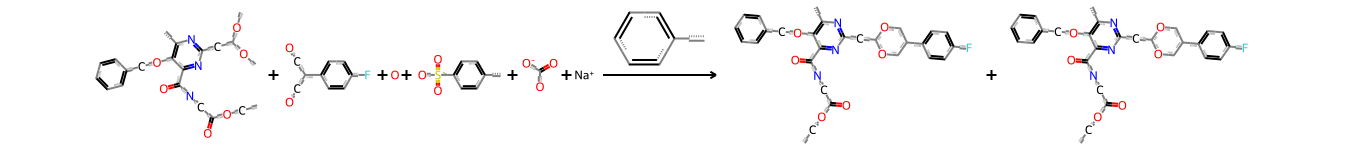

In [126]:
# Convert the reaction SMILES string to a reaction object: no mol object can be created from a reaction SMILES
rxn = rdChemReactions.ReactionFromSmarts(cleaned_rxn_smiles['reactionSmiles'][1223])

# Remove atom mapping numbers from reactants, products and agents as else one cannot see anything
for mol in rxn.GetReactants():
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
for mol in rxn.GetProducts():
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
for mol in rxn.GetAgents():
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)

# Display the reaction
print(cleaned_rxn_smiles['paragraphText'][1223])
rxn


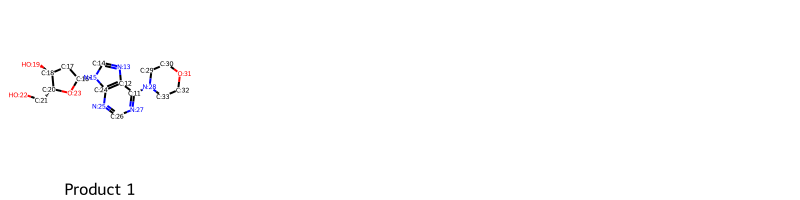

In [124]:
mol_list2 = [Chem.MolFromSmiles(smiles) for smiles in cleaned_rxn_smiles['extracted_pr_Smiles'][0]]
img = Draw.MolsToGridImage(mol_list2, molsPerRow=4, subImgSize=(200, 200), legends=[f"Product {i+1}" for i in range(len(mol_list2))])
img

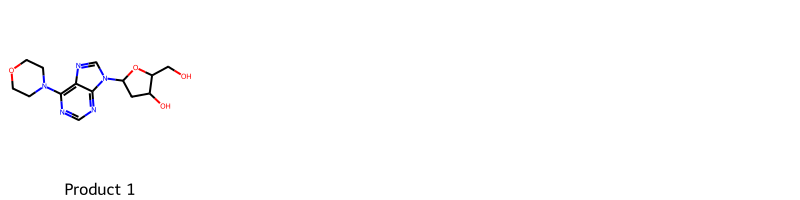

In [125]:
mol_list2 = [Chem.MolFromSmiles(smiles) for smiles in rxn_smiles['extracted_pr_Smiles'][0]]
img = Draw.MolsToGridImage(mol_list2, molsPerRow=4, subImgSize=(200, 200), legends=[f"Product {i+1}" for i in range(len(mol_list2))])
img

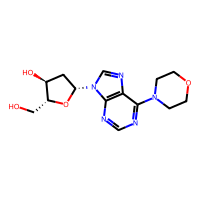

In [22]:
mol = Chem.MolFromSmiles('[C@@H:16]1([N:15]2[CH:14]=[N:13][C:12]3[C:24]2=[N:25][CH:26]=[N:27][C:11]=3[N:28]2[CH2:33][CH2:32][O:31][CH2:30][CH2:29]2)[O:23][C@H:20]([CH2:21][OH:22])[C@@H:18]([OH:19])[CH2:17]1 |f:2.3.4|')
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(0)
img = Draw.MolToImage(mol, size=(200, 200))
img

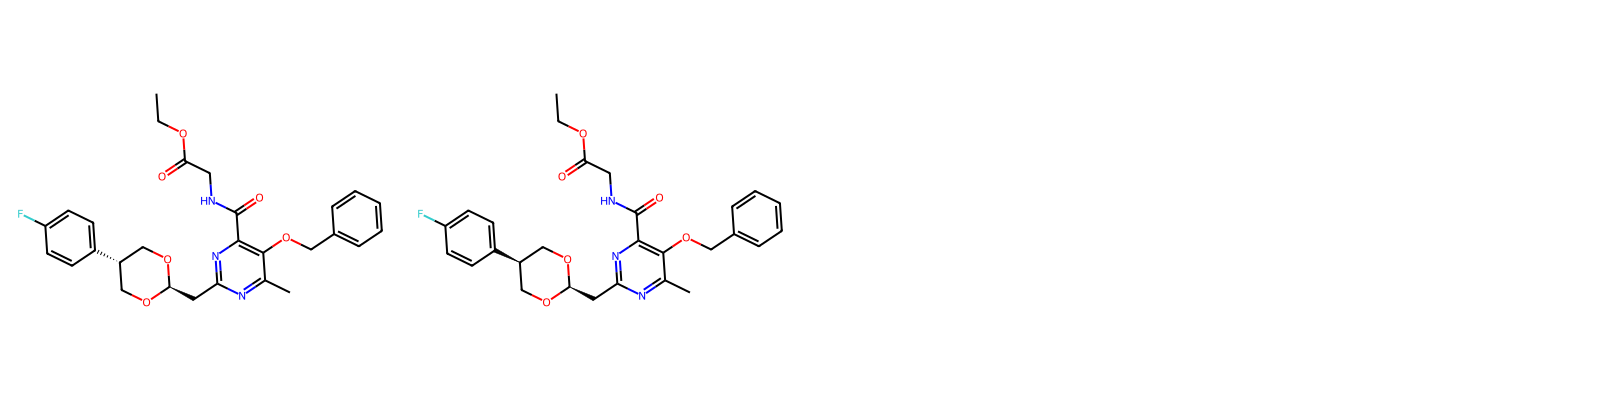

In [50]:
# create a mol grid with the molecules from the smiles list to visualize them
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(400, 400))
img

Those are nice diastereoisomers! So, what now?


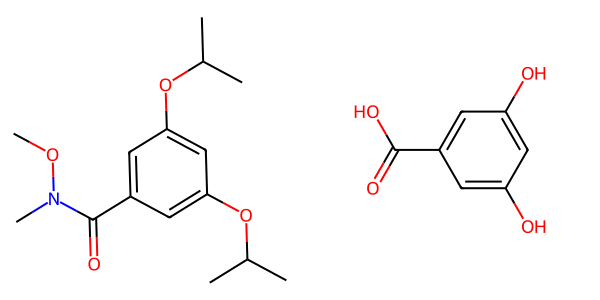

In [57]:
# This were two SMILES from the same entry
mol = Chem.MolFromSmiles('C(C)(C)OC=1C=C(C(=O)N(C)OC)C=C(C1)OC(C)C') 
mol2 = Chem.MolFromSmiles("OC=1C=C(C(=O)O)C=C(C1)O")
img = Draw.MolsToGridImage([mol, mol2], molsPerRow=2, subImgSize=(300, 300))
img

But apparently also completely different molecules. So what we need to do is either compare the product SMILES to the reaction SMILES and see if - as in the above case - there's also the reactant SMILES in the product column or if it is a by-product, drop the row as we only have one Rf value.

### 5.1.2 Processing of the SMILES
While trying to parse the product SMILES, we noted there was a problem in this column, as the format, with which it was extracted from the XML files included a double quotation. Furthermore, sometimes more product SMILES are given, if the reaction yields stereoisomers. For TLC, we don't need to distinguish between enantiomers. However, diastereoisomers of small molecules can have different Rf values, depending on their interaction with the staionary phase. So we would need to find them and drop the rows, as the LLM for sure only extracted one Rf value. 

First we need to clean the product SMILES so that it can be parsed by rdKit. That's where we use the `clean_smiles` function. Next, we need to know if we only got one product SMILES, and if so, if it is a salt. As TLCs using salts wouldn't make much sense and needs a special workup before, those entries would impact our training data and distort it. That's why we decided to also drop the salts, instead of converting them. If it turns out that there are multiple product SMILES, we check, if they are part of the product side in the reaction SMILES. Therefore, we extract the product side from the reaction SMILES. As it turned out, that the reaction SMILES are mapped by atom mapping, we need another processing step to remove the mapping and then to compare the canonicalized form of the SMILES. If this is not the case, we also drop the entire entry as we cannot be sure, to which compound the extracted Rf value belongs. Lastly, for the remaining product SMILES that are coherent with the product side of the reaction SMILES, we check if they are stereoisomers and convert them into one product SMILES without chiral information. 

In [9]:
def remove_salts(df: pd.DataFrame, column_name: str):
    """Checks if SMILES is a salt and removes it in this case.

    Args:
        df (pd.DataFrame): pre-cleaned dataframe
        column_name (str): productSmiles column

    Returns:
        df (pd.DataFrame): dataframe without rows that include salts
    """
    # Find the indices of rows where the SMILES list contains a salt
    indices_false_Rf = df[df[column_name].apply(lambda smiles_list: any('.' in smiles for smiles in smiles_list))].index 

    # Drop these rows from the DataFrame
    df.drop(indices_false_Rf, inplace=True)

    return df

In [10]:
def clean_smiles(df: pd.DataFrame, column_name: str):
    """Cleanes SMILES as apparently there are quotes around the SMILES which makes it impossible for rDKit to parse. Canonicalizes smiles

    Args:
        df (pd.DataFrame): dataframe cleaned with all previous functions
        column_name (str): productSmiles column

    Returns:
        df: pd.DataFrame: cleaned dataframe with SMILES that can be parsed in the form of a list in the column_name column
    """
    # Remove any leading or trailing whitespace
    df[column_name] = df[column_name].str.strip()
    
    # Remove any single or double quotes
    df[column_name] = df[column_name].str.replace("'", "").replace('"', '')
    
    # Split the string into a list of SMILES if there are multiple SMILES separated by a comma
    df[column_name] = df[column_name].str.split(',')
    
    # Canonicalize the SMILES
    df[column_name] = df[column_name].apply(lambda smiles_list: [Chem.MolToSmiles(Chem.MolFromSmiles(smiles)) for smiles in smiles_list])
    
    # Remove rows that contain salts
    df = remove_salts(df, column_name)
    
    return df

In [11]:
def remove_atom_mapping(mol: Chem.Mol):
    """Function that removes atom mapping from SMILES strings.

    Args:
        mol (rdkit.Chem.rdchem.Mol): Molecule with atom mapping
        
    Returns:
        smiles (str): SMILES string without atom mapping
    """
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    return Chem.MolToSmiles(mol, isomericSmiles=False)
    

In [12]:
def extract_product_smiles(df: pd.DataFrame):
    """function that extracts the product side from the reaction SMILES in the dataframe and puts it into a new column, which then is cleaned by the clean_smiles function

    Args:
        df (pd.DataFrame): dataframe cleaned with all previous functions
    """
    df['extracted_pr_Smiles'] = None
    
    for index, row in df.iterrows():
        reaction_smiles = row['reactionSmiles']
        rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles)
        
        #Extract, clean and canonicalize products
        products = [remove_atom_mapping(mol) for mol in rxn.GetProducts()]
       
        df.at[index, 'extracted_pr_Smiles'] = products
        
            
    return df




In [17]:
def validate_products(pr_mol_list: list, extr_pr_list: list):
    """checks if product smiles is also included in the extracted reaction smiles as a validation for correct processing

    Args:
        pr_mol_list (list): list of mol objects of the product SMILES
        extr_pr_list (list): list of mol objects of the extracted product SMILES
        
    Return True or False if the product SMILES are in the extracted product SMILES
    """
    # check if the product SMILES are in the extracted product SMILES by comparing the mol objects without chemical information
    
    for pr_mol in pr_mol_list:
        for atom in pr_mol.GetAtoms():
            atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_UNSPECIFIED)        
                    
    for extr_prd_mol in extr_pr_list:
        for atom in extr_prd_mol.GetAtoms():
            atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_UNSPECIFIED)         
    
    # Convert the molecule objects back to canonical SMILES strings
    pr_smiles_set = {Chem.MolToSmiles(mol) for mol in pr_mol_list}
    extr_prd_smiles_set = {Chem.MolToSmiles(mol) for mol in extr_pr_list}

    # Check if all product SMILES are in the extracted product SMILES
    return pr_smiles_set.issubset(extr_prd_smiles_set)
        
    

In [18]:
def are_enantiomers(smi1, smi2):
    """
    Function that checks if two molecules are stereoisomers. Credits to: https://github.com/rdkit/rdkit/discussions/7169 for the inspiration with the swapping of the "@" and "@@" in the SMILES strings.

    Args:
        smi1 (str): SMILES string of molecule 1
        smi2 (str): SMILES string of molecule 2

    Returns:
        tuple (Bool, int): (True, index) if the molecules are enantiomers, (False, None) otherwise
    """
    # Convert the SMILES strings to RDKit molecule objects
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)

    # If either SMILES string is invalid, return False
    if mol1 is None or mol2 is None:
        return False, None

    # Convert the molecule objects back to canonical SMILES strings
    can_smi1 = Chem.MolToSmiles(mol1)
    can_smi2 = Chem.MolToSmiles(mol2)

    # If either SMILES string does not contain "@", return False
    if "@" not in can_smi1 or "@" not in can_smi2:
        return False, None

    # Swap "@" and "@@" in can_smi1
    swapped_can_smi1 = can_smi1.replace("@@", "__DOUBLE_AT__").replace("@", "@@").replace("__DOUBLE_AT__", "@")

    # If the swapped can_smi1 is equal to can_smi2, return True
    if swapped_can_smi1 == can_smi2:
        # Find the index of the chiral atom
        for atom in mol1.GetAtoms():
            if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                return True, atom.GetIdx()
    
    # If none of the above conditions were met, return False
    return False, None

In [19]:
def check_smiles(df: pd.DataFrame):
    """Checks if the SMILES in the dataframe are unique by: comparing product SMILES and SMILES on product side of reaction SMILES, converting stereoisomers

    Args:
        df (pd.DataFrame): cleaned dataframe with SMILES that can be parsed (clean_smiles function as well as all pre-processing functions applied)
    """
    
    rows_to_drop = []
    
    for index, row in df.iterrows():
        extr_prd_smiles_list = row['extracted_pr_Smiles']
        pr_smiles_list = row['productSmiles']
        
        #Convert to mol objects
        pr_mol_list = [Chem.MolFromSmiles(smiles) for smiles in pr_smiles_list]
        extr_prd_mol_list = [Chem.MolFromSmiles(smiles) for smiles in extr_prd_smiles_list]
        
        if validate_products(pr_mol_list, extr_prd_mol_list):
            if len(pr_mol_list) > 1:
                if are_enantiomers(pr_mol_list, extr_prd_mol_list):
                    row['extracted_pr_Smiles'] = convert_enantiomers(pr_mol_list, extr_prd_mol_list)
                else:
                    rows_to_drop.append(index)
        
        
        
    return Dataframe
    
    # continue with this function and write convert_enantiomer function

In [130]:
# def convert_enantiomers(Dataframe: pd.DataFrame):
#     """
#     Function that checks if the product smiles contains a list of strings, splits them and checks, 
#     if they are enantiomers using the are_enantiomers function. If that is the case, it returns the form 
#     without stereochemistry specification.

#     Args:
#         Dataframe (pd.DataFrame): Dataframe containing the extracted data from the US patents, 
#                                 preprocessed with the get_values, clean_up and convert_solvents function.
                                
#     Returns:
#         Dataframe (pd.DataFrame): Dataframe with standardized product SMILES of only one product.
#     """
#     # as we saw, there are some rows where we got multiple product SMILES that are not enantiomers but completely different but we only got one Rf value. Time to drop again.
#     rows_to_drop = []
    
#     # Iterate over each row in the DataFrame
#     for index, row in Dataframe.iterrows():
#         # Get the product SMILES string for the current row
#         product_smiles = row['productSmiles']
        
#         # Check if the product SMILES string contains a comma, indicating multiple products
#         if ',' in product_smiles:
            
#             # Check if the first two SMILES strings in the list are enantiomers
#             are_enantiomers_result, chiral_atom_index = are_enantiomers(smiles_list[0], smiles_list[1])
#             if are_enantiomers_result:
#                 mol = Chem.MolFromSmiles(smiles_list[0])
#                 chiral_atom = mol.GetAtomWithIdx(chiral_atom_index)
#                 chiral_atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_UNSPECIFIED)
#                 Dataframe.at[index, 'productSmiles'] = Chem.MolToSmiles(mol)
                
#                 # Convert the modified molecule back to a SMILES string and update the DataFrame
#                 Dataframe.at[index, 'productSmiles'] = Chem.MolToSmiles(mol)
#              else: 
                   #rows_to_drop.append(index)

#         else:
#             try:
#                 # Remove leading and trailing apostrophes and spaces
#                 product_smiles = '"' + product_smiles + '"'
#                 product_smiles = product_smiles.replace("'", "")
#                 Dataframe.at[index, 'productSmiles'] = clean_smiles(product_smiles)
#             except product_smiles is None:
#                 rows_to_drop.append(index)
#                 continue
    
#     Dataframe = Dataframe.drop(rows_to_drop)          
                
#     # Return the modified DataFrame
#     return Dataframe

### 5.1.1 Tests after realizing that there was a problem in the product Smiles column 
Here we can clearly see, that we get two SMILES in the product column, which are separated by a comma.